In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from root_numpy import root2array, root2rec, tree2rec

branches = ['lep_pT[0]','lep_pT[1]','lep_pT[2]','lep_pT[3]','lep_pT[4]',
            'lep_eta[0]','lep_eta[1]','lep_eta[2]','lep_eta[3]','lep_eta[4]',
            'lep_phi[0]','lep_phi[1]','lep_phi[2]','lep_phi[3]','lep_phi[4]',
            'lep_m[0]','lep_m[1]','lep_m[2]','lep_m[3]','lep_m[4]',
            'lep_E[0]','lep_E[1]','lep_E[2]','lep_E[3]','lep_E[4]',
            'jet_pT[0]','jet_pT[1]','jet_pT[2]','jet_pT[3]','jet_pT[4]',
            'jet_eta[0]','jet_eta[1]','jet_eta[2]','jet_eta[3]','jet_eta[4]',
            'jet_phi[0]','jet_phi[1]','jet_phi[2]','jet_phi[3]','jet_phi[4]',
            'jet_m[0]','jet_m[1]','jet_m[2]','jet_m[3]','jet_m[4]',
            'jet_E[0]','jet_E[1]','jet_E[2]','jet_E[3]','jet_E[4]',
            'Z_pt[0]','Z_pt[1]','Z_pt[2]','Z_pt[3]','Z_pt[4]',
            'Z_phi[0]','Z_phi[1]','Z_phi[2]','Z_phi[3]','Z_phi[4]',
            'Z_eta[0]','Z_eta[1]','Z_eta[2]','Z_eta[3]','Z_eta[4]',
            'nVtx','MT2Top','MT2W','lep_n','jet_n','bjet_n','mu_n','el_n',
            'mll','HT','VecHT','HTincl','VecHTincl','MET','MET_phi']

ttbar = root2array('../Data/SleptonSignalBackground/410000.root', 'outputTree', branches=branches)
s1200_500 = root2array('../Data/SleptonSignalBackground/372462.root', 'outputTree', branches=branches)
s1400_100 = root2array('../Data/SleptonSignalBackground/372466.root', 'outputTree', branches=branches)
s1000_800 = root2array('../Data/SleptonSignalBackground/372498.root', 'outputTree', branches=branches)

In [3]:
trigger = "((channel==1 && eetrig && eetrig_match) || (channel==0 && mmtrig && mmtrig_match) || (channel>=2 && emtrig && emtrig_match))"
OSSF = "(lep_pdgId[0] == -lep_pdgId[1])"
lepReq2525 = "(lep_n>=2 && lep_pT[0]>25 && lep_pT[1]>25)"
jetReq = "(jet_n>=2 && jet_pT[0]>30 && jet_pT[1]>30)"
dPhiJetMET = "(DPhi_METJetLeading>0.4 && DPhi_METJetSecond>0.4)"

EdgeSR = trigger + " && " + OSSF + " && " + lepReq2525 + " && " + jetReq + " && " + dPhiJetMET + " && mll>12"
EdgeSRLow = EdgeSR + " && MET>200";
EdgeSRMed = EdgeSR + " && MET>250 && HT>400";
EdgeSRHigh = EdgeSR + " && MET>200 && HT>700";

SRbranches = [EdgeSRLow, EdgeSRMed, EdgeSRHigh]
ttbar_SR = root2array('../Data/SleptonSignalBackground/410000.root', 'outputTree', branches=SRbranches)
s1200_500_SR = root2array('../Data/SleptonSignalBackground/372462.root', 'outputTree', branches=SRbranches)
s1400_100_SR = root2array('../Data/SleptonSignalBackground/372466.root', 'outputTree', branches=SRbranches)
s1000_800_SR = root2array('../Data/SleptonSignalBackground/372498.root', 'outputTree', branches=SRbranches)

In [4]:
import numpy as np
from sklearn import preprocessing

ttbar = ttbar.view((float, len(ttbar.dtype.names)))
s1200_500 = s1200_500.view((float, len(s1200_500.dtype.names)))
s1400_100 = s1400_100.view((float, len(s1400_100.dtype.names)))
s1000_800 = s1000_800.view((float, len(s1000_800.dtype.names)))

ttbar_SR = ttbar_SR.view((float, 3))
s1200_500_SR = s1200_500_SR.view((float, 3))
s1400_100_SR = s1400_100_SR.view((float, 3))
s1000_800_SR = s1000_800_SR.view((float, 3))

signalType0 = np.zeros((ttbar.shape[0],1))
signalType1 = np.ones((s1200_500.shape[0],1))
signalType2 = np.ones((s1400_100.shape[0],1))*2
signalType3 = np.ones((s1000_800.shape[0],1))*3
signalType = np.concatenate((signalType0, signalType1, signalType2, signalType3), axis=0)

X = np.concatenate((s1200_500, s1400_100, s1000_800), axis=0)
background = np.zeros((ttbar.shape[0],1))
signal = np.ones((X.shape[0],1))
y = np.concatenate((background, signal), axis=0)
X = np.concatenate((ttbar, X), axis=0)

X = preprocessing.scale(X)

regions = np.concatenate((ttbar_SR, s1200_500_SR, s1400_100_SR, s1000_800_SR), axis=0)

In [5]:
def shuffle_in_unison(a, b, c, d):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)
    np.random.set_state(rng_state)
    np.random.shuffle(d)

shuffle_in_unison(X, y, regions, signalType)

In [8]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(0.95) #retain 95% variance
pca.fit(X)

X_new = pca.transform(X)

print('retained variance: %f' % sum(pca.explained_variance_ratio_))
print('%d components' % pca.n_components_)

retained variance: 0.952010
39 components


In [6]:
from sklearn.cross_validation import train_test_split

y = np.concatenate((y, regions, signalType), axis=1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=492)
region_train = y_train[:,1:4]
region_val = y_val[:,1:4]
region_test = y_test[:,1:4]
signalType_train = y_train[:,4]
signalType_val = y_val[:,4]
signalType_test = y_test[:,4]
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

In [7]:
from sknn.mlp import Regressor, Layer

def train(learning_rate=0.02, n_iter=20, m=X_train.shape[0], neurons=3, weight=1):
    nn = Regressor(layers=[Layer("Tanh", units=neurons), Layer("Tanh", units=neurons), Layer("Tanh")], learning_rate=learning_rate, n_iter=n_iter)
    if weight != 1:
        weight_train = np.ones(m)
        weight_train[y_train[0:m-1][0] == 1] = weight #weigh signal events
        nn.fit(X_train[0:m-1][:], y_train[0:m-1][:], weight_train)
    else:
        nn.fit(X_train[0:m-1][:], y_train[0:m-1][:])
    return nn

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
import matplotlib.patches as mpatches

#def plotNNTest(learning_rate=0.02, n_iter=20, neurons=7, weight=1):
def plotNNTest(*parameters):

    m = [10,30,100,300,1000,3000,10000,30000,100000]
    trainAccuracies = []
    valAccuracies = []
    trainPrecisions = []
    valPrecisions = []
    trainRecalls = []
    valRecalls = []

    for n in m:

        #nn = train(learning_rate, n_iter, n, neurons, weight)
        nn = train(parameters, m=n)

        trainAccuracy = accuracy_score(y_train[0:n-1][:], np.round(nn.predict(X_train[0:n-1][:])))
        valAccuracy = accuracy_score(y_val, np.round(nn.predict(X_val)))
        trainPrecision = precision_score(y_train[0:n-1][:], np.round(nn.predict(X_train[0:n-1][:])))
        valPrecision = precision_score(y_val, np.round(nn.predict(X_val)))
        trainRecall = recall_score(y_train[0:n-1][:], np.round(nn.predict(X_train[0:n-1][:])))
        valRecall = recall_score(y_val, np.round(nn.predict(X_val)))

        trainAccuracies.append(trainAccuracy)
        valAccuracies.append(valAccuracy)
        trainPrecisions.append(trainPrecision)
        valPrecisions.append(valPrecision)
        trainRecalls.append(trainRecall)
        valRecalls.append(valRecall)

    plt.semilogx(m,trainAccuracies,'b-')
    plt.semilogx(m,valAccuracies,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

    plt.semilogx(m,trainPrecisions,'b-')
    plt.semilogx(m,valPrecisions,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Precision")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

    plt.semilogx(m,trainRecalls,'b-')
    plt.semilogx(m,valRecalls,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Recall")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

(3, ' Neurons:')


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

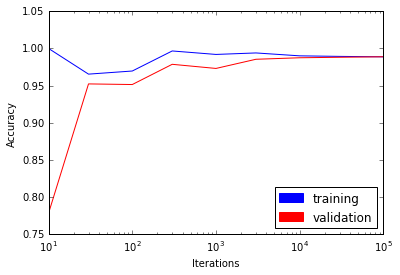

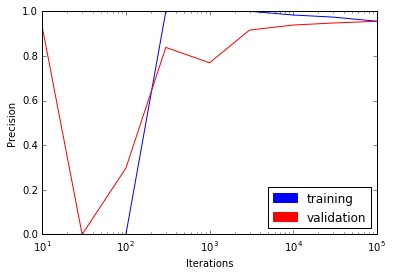

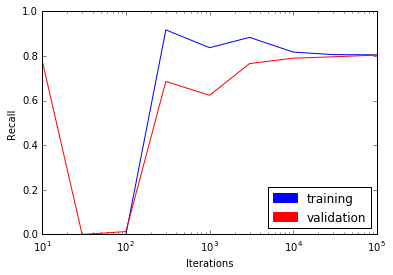

(4, ' Neurons:')


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

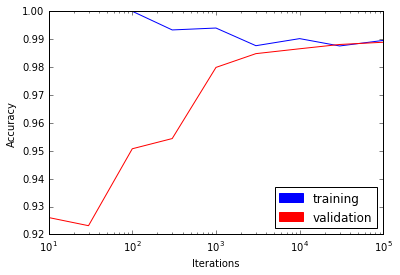

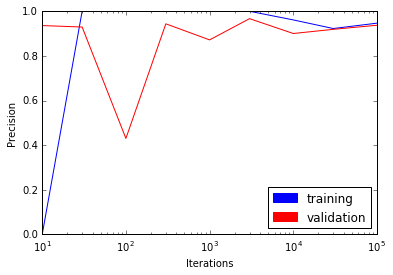

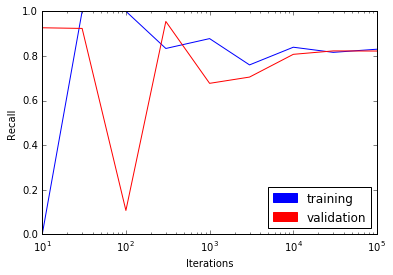

(5, ' Neurons:')


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

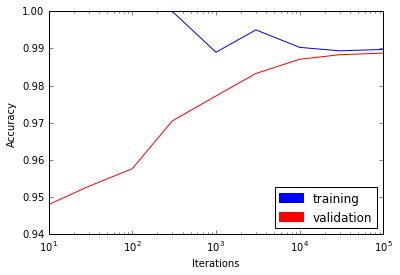

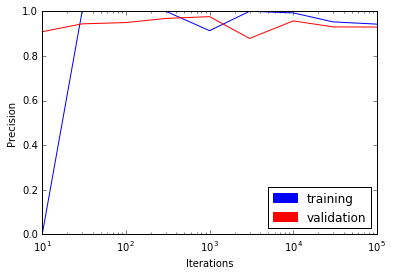

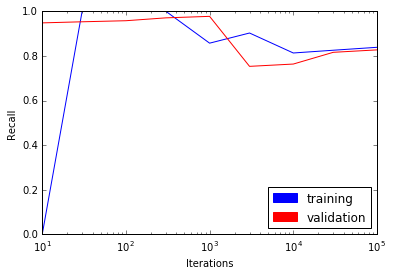

(6, ' Neurons:')


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

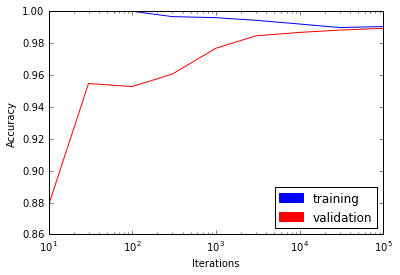

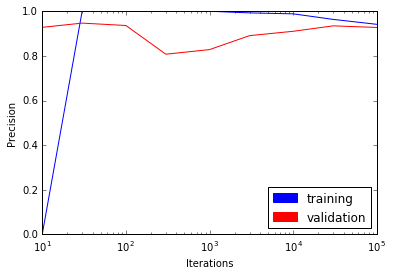

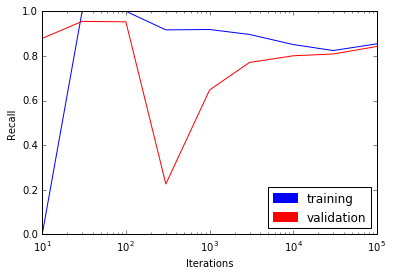

(7, ' Neurons:')


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

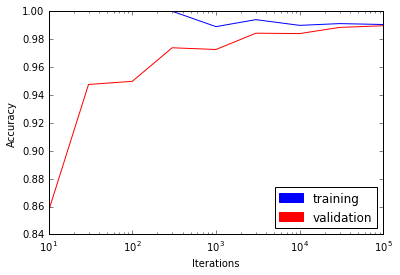

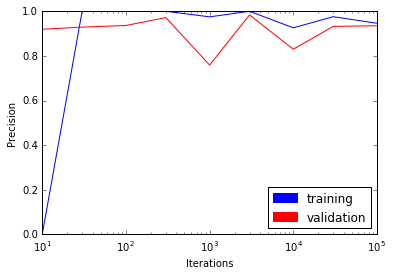

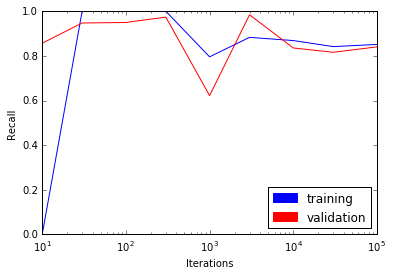

In [10]:
for i in range(3,8):
    print(i," Neurons:")
    plotNNTest(neurons=i)

('Weight:', 15)


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

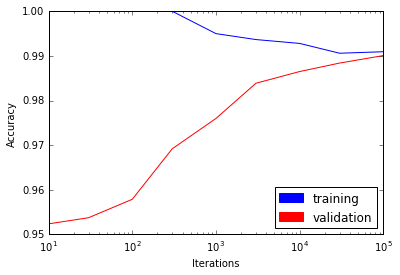

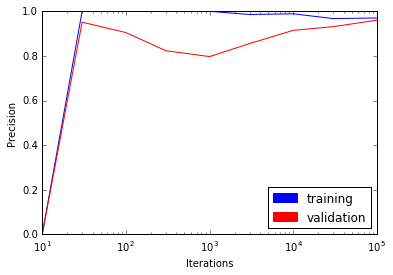

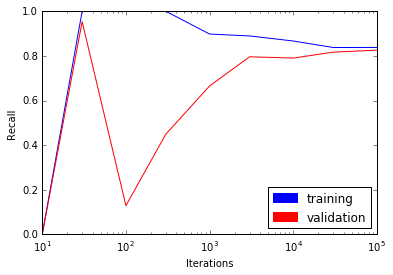

('Weight:', 20)


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

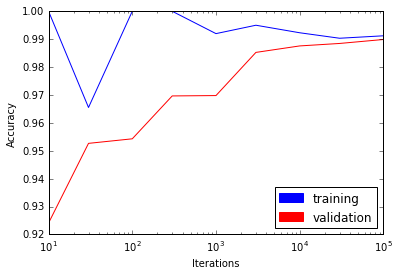

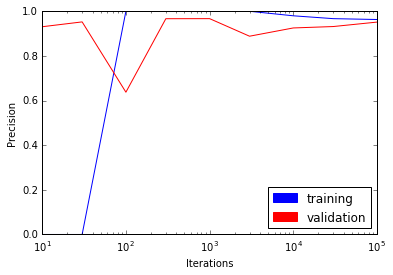

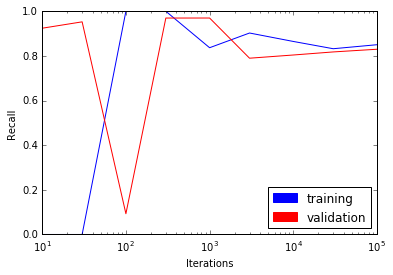

('Weight:', 25)


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

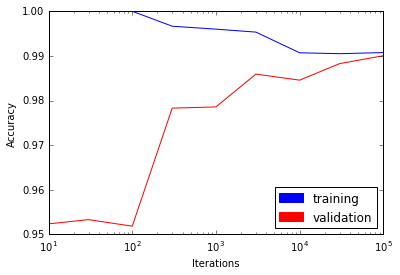

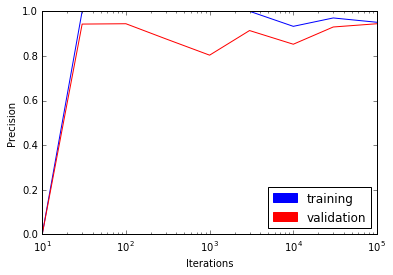

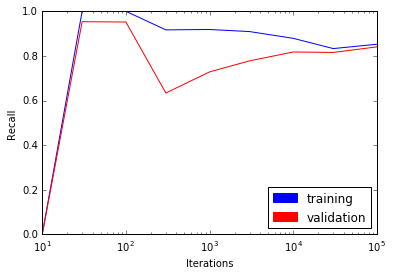

('Weight:', 30)


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

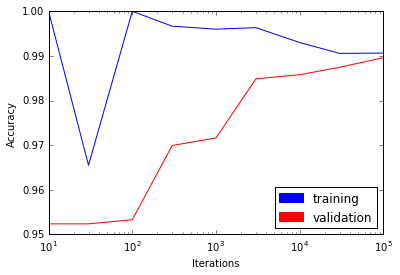

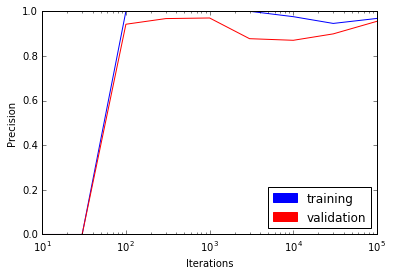

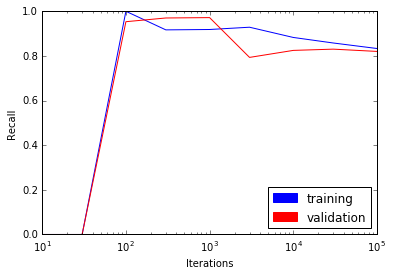

('Weight:', 35)


/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

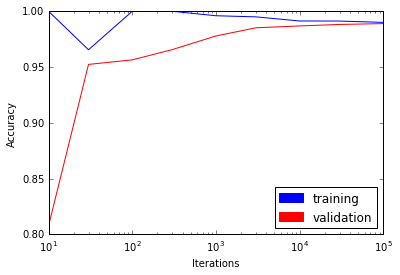

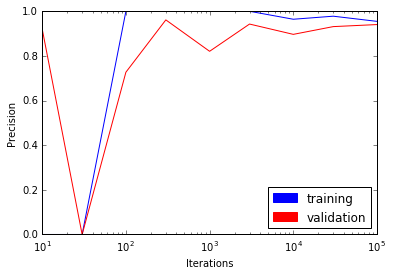

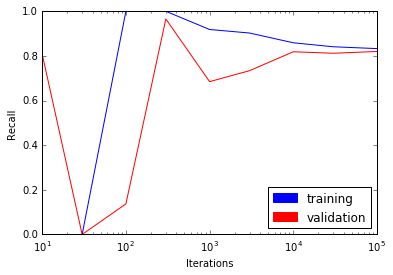

In [20]:
for i in np.arange(15,40,5):
    print("Weight:",i)
    plotNNTest(neurons=7, weight=i)

In [8]:
nn = train(neurons=7)

In [15]:
import pickle
pickle.dump(nn, open('trainedNN_20160506.pkl', 'wb'))

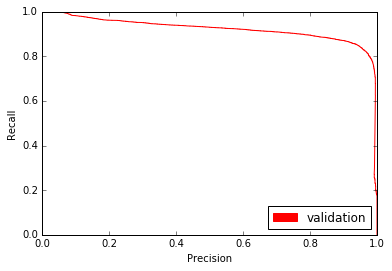

In [71]:
valRawPredictions = nn.predict(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, valRawPredictions)
plt.plot(precisions,recalls,'r-')
plt.xlabel("Precision")
plt.ylabel("Recall")
valLine = mpatches.Patch(color='red', label='validation')
plt.legend(handles=[valLine], loc='lower right')
plt.show()

In [101]:
i=125341
print(precisions[i])
print(recalls[i])
print(thresholds[i])

0.93574547723
0.854579119784
0.499692261217


In [9]:
threshold = 0.5
dt = threshold-0.5

In [12]:
testAccuracy = accuracy_score(y_test, np.round(nn.predict(X_test) - dt))
testPrecision = precision_score(y_test, np.round(nn.predict(X_test) - dt))
testRecall = recall_score(y_test, np.round(nn.predict(X_test) - dt))

print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.99, Precision: 0.96, Recall: 0.83


In [13]:
for i in range(0,3):
    X_SR = X_test[region_test[:,i] == 1]
    y_SR = y_test[region_test[:,i] == 1]
    testAccuracy = accuracy_score(y_SR, np.round(nn.predict(X_SR) - dt))
    testPrecision = precision_score(y_SR, np.round(nn.predict(X_SR) - dt))
    testRecall = recall_score(y_SR, np.round(nn.predict(X_SR) - dt))
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.95, Precision: 0.98, Recall: 0.96
Accuracy: 0.97, Precision: 0.99, Recall: 0.97
Accuracy: 0.98, Precision: 0.99, Recall: 0.98


In [14]:
for i in range(0,4):
    X_signal = X_val[signalType_test == i]
    y_signal = y_val[signalType_test == i]
    testAccuracy = accuracy_score(y_signal, np.round(nn.predict(X_signal) - dt))
    testPrecision = precision_score(y_signal, np.round(nn.predict(X_signal) - dt))
    testRecall = recall_score(y_signal, np.round(nn.predict(X_signal) - dt))
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.99, Precision: 0.96, Recall: 0.84
Accuracy: 0.99, Precision: 0.99, Recall: 0.78
Accuracy: 0.99, Precision: 0.93, Recall: 0.81
Accuracy: 0.99, Precision: 0.93, Recall: 0.80


In [49]:
from sklearn import svm

def trainSVM(m=X_train.shape[0]):
    clf = svm.SVC(kernel='rbf')
    X_matrix = X_train[0:m-1][:]
    y_vec = y_train[0:m-1]
    clf.fit(X_matrix, y_vec)
    return clf

def plotSVMTest():

    m = [30,100,300,1000,3000,10000,30000,100000]
    trainAccuracies = []
    valAccuracies = []
    trainPrecisions = []
    valPrecisions = []
    trainRecalls = []
    valRecalls = []

    for n in m:

        clf = trainSVM(m=n)

        trainAccuracy = accuracy_score(y_train[0:n-1][:], np.round(clf.predict(X_train[0:n-1][:])))
        valAccuracy = accuracy_score(y_val, np.round(clf.predict(X_val)))
        trainPrecision = precision_score(y_train[0:n-1][:], np.round(clf.predict(X_train[0:n-1][:])))
        valPrecision = precision_score(y_val, np.round(clf.predict(X_val)))
        trainRecall = recall_score(y_train[0:n-1][:], np.round(clf.predict(X_train[0:n-1][:])))
        valRecall = recall_score(y_val, np.round(clf.predict(X_val)))

        trainAccuracies.append(trainAccuracy)
        valAccuracies.append(valAccuracy)
        trainPrecisions.append(trainPrecision)
        valPrecisions.append(valPrecision)
        trainRecalls.append(trainRecall)
        valRecalls.append(valRecall)

    plt.semilogx(m,trainAccuracies,'b-')
    plt.semilogx(m,valAccuracies,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

    plt.semilogx(m,trainPrecisions,'b-')
    plt.semilogx(m,valPrecisions,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Precision")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

    plt.semilogx(m,trainRecalls,'b-')
    plt.semilogx(m,valRecalls,'r-')
    plt.xlabel("Iterations")
    plt.ylabel("Recall")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

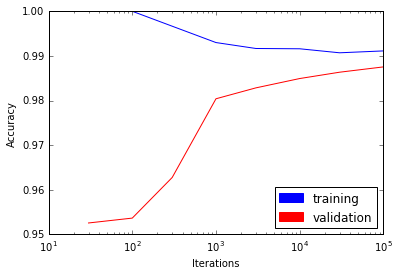

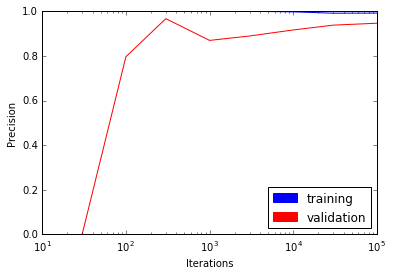

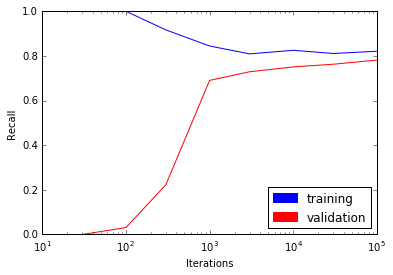

In [50]:
plotSVMTest()

In [51]:
clf = trainSVM()

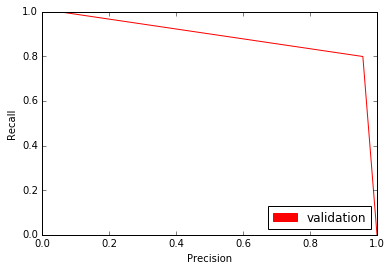

In [52]:
valRawPredictions = clf.predict(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, valRawPredictions)
plt.plot(precisions,recalls,'r-')
plt.xlabel("Precision")
plt.ylabel("Recall")
valLine = mpatches.Patch(color='red', label='validation')
plt.legend(handles=[valLine], loc='lower right')
plt.show()

In [70]:
threshold = 0.5

testAccuracy = accuracy_score(y_val, np.round(clf.predict(X_val) - (threshold-0.5)))
testPrecision = precision_score(y_val, np.round(clf.predict(X_val) - (threshold-0.5)))
testRecall = recall_score(y_val, np.round(clf.predict(X_val) - (threshold-0.5)))

print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.99, Precision: 0.96, Recall: 0.80


In [64]:
for i in range(0,3):
    X_SR = X_test[region_test[:,i] == 1]
    y_SR = y_test[region_test[:,i] == 1]
    testAccuracy = accuracy_score(y_SR, np.round(clf.predict(X_SR) - (threshold-0.5)))
    testPrecision = precision_score(y_SR, np.round(clf.predict(X_SR) - (threshold-0.5)))
    testRecall = recall_score(y_SR, np.round(clf.predict(X_SR) - (threshold-0.5)))
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.95, Precision: 0.99, Recall: 0.95
Accuracy: 0.97, Precision: 0.99, Recall: 0.98
Accuracy: 0.98, Precision: 0.99, Recall: 0.99


In [65]:
for i in range(0,4):
    X_signal = X_test[signalType_test == i]
    y_signal = y_test[signalType_test == i]
    testAccuracy = accuracy_score(y_signal, np.round(clf.predict(X_signal) - (threshold-0.5)))
    testPrecision = precision_score(y_signal, np.round(clf.predict(X_signal) - (threshold-0.5)))
    testRecall = recall_score(y_signal, np.round(clf.predict(X_signal) - (threshold-0.5)))
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f" % (testAccuracy, testPrecision, testRecall))

Accuracy: 1.00, Precision: 0.00, Recall: 0.00
Accuracy: 0.90, Precision: 1.00, Recall: 0.90
Accuracy: 0.99, Precision: 1.00, Recall: 0.99
Accuracy: 0.37, Precision: 1.00, Recall: 0.37


In [81]:
regions = ['Low', 'Medium', 'High']
signals = ['ttbar', 's1200_500', 's1400_100', 's1000_800']

for j in range(0,3):
    print(regions[j])
    for i in range(1,4):
        print(signals[i])
        pass_signal = signalType_test == i
        pass_region = region_test[:,j] == 1
        pass_all = np.multiply(pass_signal, pass_region)
        X_signal = X_test[pass_all]
        print(sum(np.round(nn.predict(X_signal) - (threshold-0.5))))

Low
s1200_500
[ 1291.]
s1400_100
[ 1554.]
s1000_800
[ 251.]
Medium
s1200_500
[ 1038.]
s1400_100
[ 1401.]
s1000_800
[ 121.]
High
s1200_500
[ 605.]
s1400_100
[ 1459.]
s1000_800
[ 50.]


In [71]:
nn.get_parameters()

[Parameters(weights=array([[  6.08139355e-02,   9.06001640e-01,  -2.47265191e-01,
         -7.93729852e-02,   1.35601477e+00,   1.96198374e-01,
          1.24866837e+00],
       [ -3.27639190e-01,   2.17516166e+00,  -7.66943044e-01,
          4.48988605e-02,  -5.75709908e-01,   1.33368024e-01,
          1.20453606e+00],
       [ -3.64661983e+00,   2.11956393e+00,  -1.80433758e+00,
          1.51863044e+00,  -1.62971353e+00,   2.00508842e+00,
          1.79809747e+00],
       [ -3.49923125e-01,   4.65066091e-01,  -4.87868808e-01,
          5.14172664e-01,  -3.43202875e-01,   4.39213136e-01,
          4.03633708e-01],
       [ -1.41458100e+00,   8.22252978e-01,  -1.18342276e-01,
         -4.37013751e-02,  -3.13053158e-01,  -1.80346079e-01,
          2.06554324e-01],
       [ -3.06968472e-01,   2.29097395e-01,   7.89045008e-02,
         -9.28320039e-02,   1.79552759e-01,  -9.89045913e-02,
          1.32269500e-01],
       [ -4.05177469e-02,  -3.35815850e-02,  -6.25388782e-02,
         -3.